### Name : Mathieu LAMIOT, Sohyeong KIM

# Chapter 3: Object Tracking (Face Tracking)

## Part 2: Meanshift and Camshift.


In this subsection, you will now use _meanshift_ and the _camshift_ algorithms for object tracking. The Meanshift algorithm was originally presented as a clustering technique, which was then adapted for object tracking. On the other hand, the "Continuously  Adaptive  Meanshift"  algorithm (CamShift) is an extension of the Meanshift algorithm for object tracking in more general situations.

MeanShift is nothing but an algorithm for finding modes in a set of data samples representing an underlying probability density function (PDF) in $R^N$. It is a nonparametric clustering technique which does not require prior knowledge of the number of clusters and does not constrain the shape of the clusters.

In this section, you will use the OpenCV documentation to apply the aforementioned methods to a video file. Similar to the previous notebook you will use any high level (already implemented) function from OpenCV to complete the exercise specifications and outputs. The aim of this exercise is focused on __evaluating you capacity to search and understand basic image processing functions from OpenCV to complete the task__.


__Section Objectives:__

* Understand the use of the Meanshift and Camshift algorithm using OpenCV for face tracking.

* Apply them to video data and extract the results.

* Compare and evaluate the performance between them and a given ground truth

__Data__

For this assignment, you will use the data videos on ``../data/videos/`` labelled as "video_girl.avi". The ground truth (the solution or gold standard of the exercise) is included in the file: "video_girl_groundtruth_rect.txt". You will later use these results to compute the accuracy of your tracking. 


__Groundtruth__

The ground truth contains a list of four numbers per frame. Each line lists the __row, column, width and height__ of the face position.



## Meanshift 


Meanshift is a non-parametric feature-space analysis technique for locating the maxima of a density function, a so-called mode-seeking algorithm. It was originally presented in 1975 by Fukunaga and Hostetler paper, as a clustering algorithm. The mean shift algorithm can be used for visual tracking. The simplest such algorithm would create a confidence map in the new image based on the colour histogram of the object in the previous image and use Meanshift to find the peak of a confidence map near the object's old position. OpenCV provides a useful tutorial and example in its official documentation: 

https://docs.opencv.org/3.4.1/db/df8/tutorial_py_meanshift.html


As the first exercise, you will use the Meanshift function inside OpenCV to do face tracking. You will use your previously defined function (from the first assignment) to apply the Meanshift function over the first __50 frames__ of the video "video_girl.avi" and save the coordinates of the __region detected by the algoritmh__. As you can see (once you read the documentation and the example), mean-shift requires an initial mask region to perform the following tracking; you will use the first region listed in the ground truth file as an initial region.


Specifications: 

* The implemented solution should use the same function implemented in the first part.
* The output should contain a list of the rectangle region obtained from Meanshift over the first 50 frames.
* The function should receive as the parameter all the parameters needed to call the Meanshift function over the video.  This means that a user shouldn't need to modify the function internal code to test any set of parameters. 
* To corroborate your results, display the frame with the output rectangle region drawn in it, for the frames 1, 25 and 50.  



In [1]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
from utils import *
import matplotlib.pyplot as plt

%matplotlib inline

#Import all the extra you may need.

In [2]:
# Using same function from the previous lab 

def transformVideoFile(file_path, function, params ):
    """
    Given the path of a video file (file_path) the function reads every frame of the input video and applies a given
    transformation (function) usign the parameters (params)

    :input_image:       Input video file path 
    : function           Function be applied to each frame of the image.
    : params             Any parameter needed for the function above.
    :return:            output_handler this can be anything you may need to dave your results.
    """
    
    image = [];
    vidcap = cv.VideoCapture(file_path)
    count = 0
    output_handler = []
    second_output = []
    
    # Retrieve the parameters
    stop_param = params[-1] # Parameters to limit the process
    if( (type(stop_param) == int) ): # Stop parameter should be a positive integer
        if(stop_param > 0):
            func_param = params[0:-1] # Parameters for the function
            stop_flag = True
        else:
            func_param = params[:] # Parameters for the function
            stop_flag = False
    else:
        func_param = params[:] # Parameters for the function
        stop_flag = False
    
    # Find the frame per second
    fps = vidcap.get(cv.CAP_PROP_FPS)
    frame_cnt = vidcap.get(cv.CAP_PROP_FRAME_COUNT)
    
    while vidcap.isOpened():
        # Capture frame-by-frame
        success, image = vidcap.read()  
        if success:
            ## For each frame in the video:
            img_handled = function(image,func_param)
            output_handler.append(img_handled)
            
            # For every second in the video:
            if(count % fps == 0):
                second_output.append(img_handled)
                print('Processing {}th frame out of {}'.format(count+1, int(frame_cnt)))
            
            # For limited length of process:
            if(stop_flag):
                if(count == (stop_param-1)):
                    print('Stopping proess at {}th frame'.format(count+1))
                    break
            
            # Update the count
            count += 1
        else:
            break
    
    # When everything done, release the video capture object
    vidcap.release()

    # Output
    all_output = output_handler
    print('Processed {} number of the frames in total.'.format(len(all_output)))
    
    return all_output, second_output

In [3]:
# Function that checks the mask for selected range

def check_mask(img_file_path, gt_file_path, param):
    ## ----- Retrieve useful parameters
    range_low = param[0]
    range_high = param[1]
    
    ## ----- Initialize the mask region to perform the following tracking

    # Retrieve first 4 numbers of the ground truth file
    theFile = open(gt_file_path, "r");
    theInts = []
    for val in theFile.read().split():
        theInts.append(int(val))
    theFile.close()

    # Set up the c, r, w, h, values
    r,c,w,h = theInts[0],theInts[1],theInts[2],theInts[3] 
    track_window = (r,c,w,h)
    
    # Get the region of interest
    vidcap = cv2.VideoCapture(img_file_path)
    ret,frame = vidcap.read()
    roi = frame[c:c+h, r:r+w]
    vidcap.release()
    
    ## ------ Get the mask and output image
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_roi, range_low, range_high)    
    #toto = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    return mask

-

In [4]:
def process_frame_meanshift(image,params):
    
    global track_window;

    #Retrieve useful parameters
    roi_hist = params[0];
    term_crit = params[1];

    # Apply the algorithm on the frame
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsv],[0,1],roi_hist,params[3],1)
    
    # Apply meanshift to get the new location
    ret, track_window = cv.meanShift(dst, track_window, term_crit)


    return [image, track_window]; 

In [5]:
def meanShiftFromVideoFile(img_file_path, function,  gt_file_path, params):
    
    global track_window;
    
    ## ----- Retrieve useful parameters
    range_low = params[0]
    range_high = params[1]
    stop = params[-1] # Number of a frame that we want to stop.
    
    
    ## ----- Initialize the mask region to perform the following tracking

    # Retrieve first 4 numbers of the ground truth file
    theFile = open(gt_file_path, "r");
    theInts = []
    for val in theFile.read().split():
        theInts.append(int(val))
    theFile.close()

    # Set up the c, r, w, h, values
    r,c,w,h = theInts[0],theInts[1],theInts[2],theInts[3] 
    track_window = (r,c,w,h)
    
    # Get the region of interest
    vidcap = cv2.VideoCapture(img_file_path)
    ret,frame = vidcap.read()
    roi = frame[c:c+h, r:r+w]
    vidcap.release()
    
    
    ## ------ Set-up the histogram reference  
    
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_roi, range_low, range_high)
    roi_hist = cv.calcHist([hsv_roi],[0,1],mask,\
                           [range_high[0]-range_low[0],range_high[2]-range_low[2]],\
                           [range_low[0],range_high[0],range_low[2],range_high[2]])
    cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

    ##------- Set-up the termination criterion
    term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

    ##------- Process the videos
    output_handler, dummy = transformVideoFile(img_file_path, function, \
                                               [roi_hist,term_crit,track_window,\
                                                [range_low[0],range_high[0],range_low[2],range_high[2]],\
                                                stop]);
    output = output_handler
    return output

In [6]:
# Set up the file paths
img_file_path =  os.path.join('..','data', 'videos', 'video_girl.avi')
gt_file_path = os.path.join('..','data', 'videos', 'video_girl_groundtruth_rect.txt.txt')

# Set the input parameters (mask_range_low, mask_range_high, stopping frame)
in_params = [ np.array((10., 0.,0.)), np.array((30.,255.,255.)), 50]


# Do the meanshift on the targeted video
meanshift_output = meanShiftFromVideoFile(img_file_path, process_frame_meanshift, gt_file_path, in_params)


Processing 1th frame out of 500
Processing 16th frame out of 500
Processing 31th frame out of 500
Processing 46th frame out of 500
Stopping proess at 50th frame
Processed 50 number of the frames in total.


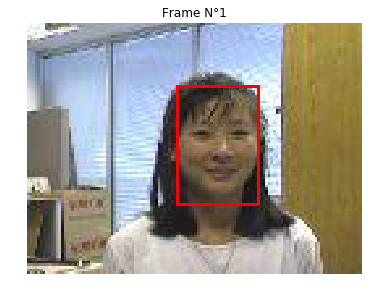

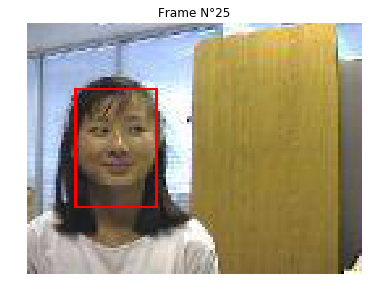

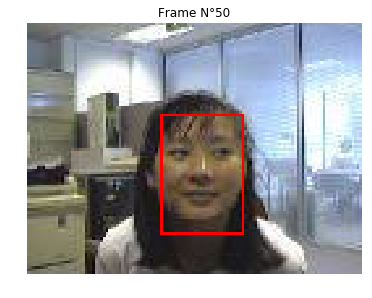

In [7]:
## Be sure to display the results below:
## Frame number
## Display image frame (1, 25, 50)

to_display = [1, 25, 50]

for kk in to_display:
    output = meanshift_output[kk-1]
    image = cv.cvtColor(output[0], cv.COLOR_BGR2RGB)
    x,y,w,h = output[1]
    img = cv.rectangle(image, (x,y), (x+w,y+h), 255,1)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img)
    ax.set_title('Frame N°{}'.format(kk))
    ax.axis('off')
    plt.show()

### Hints 

* As mentioned before, this exercise will evaluate your capacity to understand and adapt the example code from the aforementioned tutorial to solve the exercise. However, feel free to search and use any other example/code that you may find.
* Be sure to understand each line from the suggested example. Some parts you should pay attention to are:
  * What are the hardcoded values given to the functions: inRange, calcHist and calcBackProject? 
  * Are those the best values for my input? 
  * How does the mask looks like? 
* Notice that the ground truth contains the row, column, width, height. In the example, they have different input order.
* Finally, notice that in this tutorial they use the HSV colour space, specifically the first channel. Why is this? 

## Camshift

Continuously adaptive mean-shift(CAMShift) was proposed as an efficient and light-weight tracking algorithm developed based on mean-shift. What Camshift do is nothing but do meanShift in every single frame of a video, and adapt the parameters and the window using (a very basic) backpropagation. With this simple idea, however, Camshift is able to track objects in multiscale situations. On the other hand, it makes Camshift much more sensible to lightning changes or obfuscation problems. 


As a second exercise, you will test the Camshift algorithm from OpenCV following the same specifications to the same first __50 initial frames__. You can use a different set of parameters to test, the main shift and make it work.

In [8]:
def camShiftFromVideoFile(img_file_path, function,  gt_file_path, params):
    
    global track_window;
    
    ## ----- Retrieve useful parameters
    range_low = params[0]
    range_high = params[1]
    stop = params[-1] # Number of a frame that we want to stop.
    
    
    ## ----- Initialize the mask region to perform the following tracking

    # Retrieve first 4 numbers of the ground truth file
    theFile = open(gt_file_path, "r");
    theInts = []
    for val in theFile.read().split():
        theInts.append(int(val))
    theFile.close()

    # Set up the c, r, w, h, values
    r,c,w,h = theInts[0],theInts[1],theInts[2],theInts[3] 
    track_window = (r,c,w,h)
    
    # Get the region of interest
    vidcap = cv2.VideoCapture(img_file_path)
    ret,frame = vidcap.read()
    roi = frame[c:c+h, r:r+w]
    vidcap.release()
    
    
    ## ------ Set-up the histogram reference  
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_roi, range_low, range_high)
    roi_hist = cv.calcHist([hsv_roi],[0,1],mask,\
                           [range_high[0]-range_low[0],range_high[2]-range_low[2]],\
                           [range_low[0],range_high[0],range_low[2],range_high[2]])
    cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

    ##------- Set-up the termination criterion
    term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

    ##------- Process the videos
    output_handler, dummy = transformVideoFile(img_file_path, function, \
                                               [roi_hist, term_crit, track_window,\
                                                [range_low[0],range_high[0],range_low[2],range_high[2]],\
                                                stop]);
    output = output_handler
    return output

In [9]:
def process_frame_camshift(image,params):

    global track_window;

    #Retrieve useful parameters
    roi_hist = params[0];
    term_crit = params[1];

    # Apply the algorithm on the frame
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsv],[0,1],roi_hist,params[3],1)
    
    # Apply camshift to get the new location
    ret, track_window = cv.CamShift(dst, track_window, term_crit)
    
    return [image, ret]; 

In [10]:
# Set up the file paths
img_file_path =  os.path.join('..','data', 'videos', 'video_girl.avi')
gt_file_path = os.path.join('..','data', 'videos', 'video_girl_groundtruth_rect.txt.txt')

# Set the input parameters (mask_range_low, mask_range_high, stopping frame)
in_params = [np.array((10., 80, 90.)), np.array((20.,150.,180.)), 50]


# Do the meanshift on the targeted video
camshift_output = camShiftFromVideoFile(img_file_path, process_frame_camshift, gt_file_path, in_params)

Processing 1th frame out of 500
Processing 16th frame out of 500
Processing 31th frame out of 500
Processing 46th frame out of 500
Stopping proess at 50th frame
Processed 50 number of the frames in total.


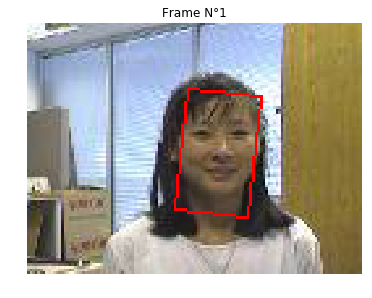

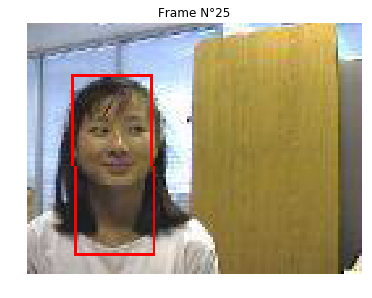

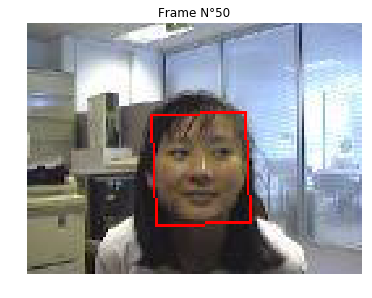

In [11]:
## Be sure to display the results below:
## Frame number
## Display image frame (1, 25, 50)
to_display = [1, 25, 50]

for kk in to_display:
    output = camshift_output[kk-1]
    image = cv.cvtColor(output[0], cv.COLOR_BGR2RGB)

    pts = cv.boxPoints(output[1])
    pts = np.int0(pts)
    img = cv.polylines(image,[pts],True, 255,1)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img)
    ax.set_title('Frame N°{}'.format(kk))
    ax.axis('off')
    plt.show()        

# Comparision metrics

For the last part of the assignment, you are asked to compare the performance of the Camshift tracker and the Meanshift tracker, frame wise, in terms of average Intersection over Union (IoU) of the object ground truth bounding boxes during the first __50 frames__; which is basically the ratio between the area of the intersection over the union.

You can find the metric as the Jaccard index https://en.wikipedia.org/wiki/Jaccard_index. Feel free to modify the implementation below to adapt it to your function output.



In [12]:
def IoU(boxgt, boxcal, camshift= False, bg_size=(255,255,3)):
    
    '''
    Inputs: 
        boxgt: top left and bottom right coordinates of the ground truth Box 
        boxcal: top left and bottom right coordinates of the calculated Box
        camshift : True if boxcal is the result of the camshift. 
        bg_size : size of the black image that will be used as a background

    '''
    # Create the blank image 
    blank_img = np.zeros(bg_size, np.uint8)
   
    # Project the ground turth box on the blank image (inside the box = nonzero)
    xgt1, ygt1, xgt2, ygt2 = boxgt
    gt_img = cv.rectangle(blank_img.copy(),(xgt1, ygt1), (xgt2, ygt2),(255,255,255),-1)
    gt_img = cv.cvtColor(gt_img, cv.COLOR_RGB2GRAY)
 
    # Project the calculated box on the blank image (inside the box = nonzero)
    if(camshift): 
        # If boxcal is the result of the camshift
        cal_img = cv.fillPoly(blank_img.copy(),[boxcal],color = (255,255,255))
        cal_img = cv.cvtColor(cal_img, cv.COLOR_RGB2GRAY)
    else:
        # If the boxcal is the result of the meanshift
        xcal1, ycal1, xcal2, ycal2 = boxcal
        cal_img = cv.rectangle(blank_img.copy(),(xcal1, ycal1), (xcal2, ycal2),(255,255,255),-1)
        cal_img = cv.cvtColor(cal_img, cv.COLOR_RGB2GRAY)
        
    # compute the area of intersection rectangle
    interArea = np.sum( ((gt_img & cal_img)>0).astype(np.int8) )

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxgtArea = np.sum( (gt_img >0).astype(np.int8) )
    boxcalArea = np.sum( (cal_img >0).astype(np.int8))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxgtArea + boxcalArea - interArea)

    # return the intersection over union value
    return iou


IoU([39, 63, 203, 112],[40, 63, 205, 112])

0.9820359281437125

In [13]:
## ----- Create a ground turth boxes list

# Initialize the parameter
theInts =[]
gt_box = []
iteration = 0

# Do the opeartion to store the data from txt file
theFile = open(gt_file_path, "r")
for val in theFile.read().split():
    #print('.......',iteration,'... val =', val)
    theInts.append(int(val))
    
    if(iteration % 4 == 3):
        # Add top left and bottom left of the ground turth to the list.
        r,c,w,h = theInts[0],theInts[1],theInts[2],theInts[3] 
        #print('Original value is ', [r,c,w,h])
        #print('Added value is ', [theInts[0], theInts[1], c+h, r+w])
        gt_box.append([r, c, r+w, c+h])        
        # Reset the basket
        theInts =[]
    
    # Increase the iteration
    iteration += 1

theFile.close()


The results of IoU between the Meanshift and the ground truth:
  - Mean : 0.7363380199892133
  - Min : 0.5601659751037344
  - Max : 0.9148936170212766



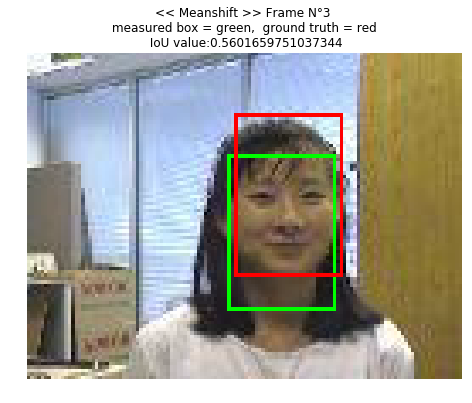

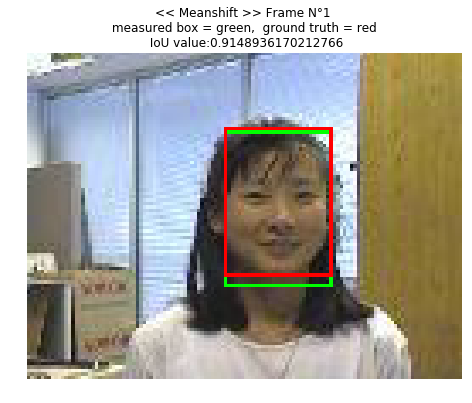

In [14]:
## ----- Calculate IoU of meanshift squares 
meanshift_IoU =[]
for ms_frame, gt_box_val in zip(meanshift_output, gt_box) :
    # Get a meanshift square box points
    rect_val = ms_frame[1]
    r,c,w,h = rect_val[0],rect_val[1],rect_val[2],rect_val[3] 
    meanshift_box = [r, c, r+w, c+h]
    
    # Calculate the IoU and append it 
    meanshift_IoU.append(IoU(gt_box_val,meanshift_box))   
    
    
#------ Report and display the result
print('The results of IoU between the Meanshift and the ground truth:\n',
      ' - Mean : {}\n'.format(np.mean(meanshift_IoU)),
      ' - Min : {}\n'.format(np.min(meanshift_IoU)),
      ' - Max : {}\n'.format(np.max(meanshift_IoU)),
     )

to_display =[np.argmin(meanshift_IoU), np.argmax(meanshift_IoU)]
to_value = [np.min(meanshift_IoU), np.max(meanshift_IoU)]

for kk, val in zip(to_display, to_value):
    output = meanshift_output[kk]
    image = cv.cvtColor(output[0], cv.COLOR_BGR2RGB)
    
    # meanshift 
    x,y,w,h = output[1]
    img = cv.rectangle(image, (x,y), (x+w,y+h), (0,255,0),1)
    # Ground truth 
    x2,y2,w2,h2 = gt_box[kk]
    img = cv.rectangle(image, (x2,y2), (w2, h2), (255,0,0),1)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(image)
    ax.set_title('<< Meanshift >> Frame N°{} \n measured box = green,  ground truth = red \n IoU value:{}'.format(kk, val))
    ax.axis('off')
    plt.show() 


The results of IoU between the Camshift and the ground truth:
  - Mean : 0.6338533628971385
  - Min : 0.5091120589375727
  - Max : 0.8415716096324461



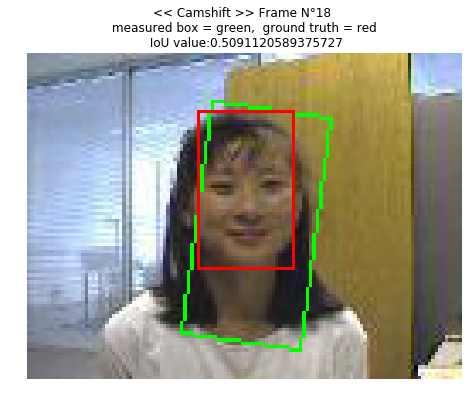

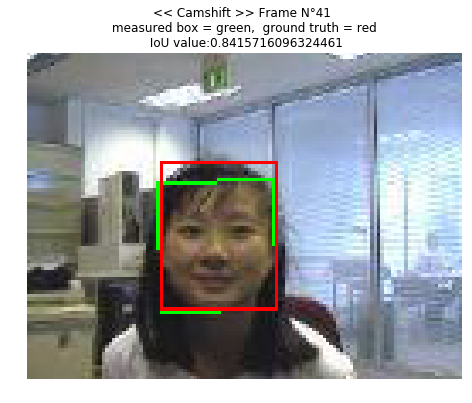

In [15]:
## ----- Calculate IoU of camshift squares
camshift_IoU =[]
for cs_frame, gt_box_val in zip(camshift_output, gt_box):
    # Get a camshift square box points
    pts = cv.boxPoints(cs_frame[1])
    pts = np.int0(pts)
    camshift_box = pts
    
    # Calculate the IoU and append it 
    camshift_IoU.append(IoU(gt_box_val,camshift_box, True))
    

    
#------ Report and display the result
print('The results of IoU between the Camshift and the ground truth:\n',
      ' - Mean : {}\n'.format(np.mean(camshift_IoU)),
      ' - Min : {}\n'.format(np.min(camshift_IoU)),
      ' - Max : {}\n'.format(np.max(camshift_IoU)),
     )

to_display =[np.argmin(camshift_IoU), np.argmax(camshift_IoU)]
to_value = [np.min(camshift_IoU), np.max(camshift_IoU)]

for kk, val in zip(to_display, to_value):
    output = camshift_output[kk]
    image = cv.cvtColor(output[0], cv.COLOR_BGR2RGB)

    # Camshift
    pts = cv.boxPoints(output[1])
    pts = np.int0(pts)
    img = cv.polylines(image,[pts],True, (0,255,0),1)
    
    # Ground truth 
    x2,y2,w2,h2 = gt_box[kk]
    img = cv.rectangle(image, (x2,y2), (w2, h2), (255,0,0),1)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(image)
    ax.set_title('<< Camshift >> Frame N°{} \n measured box = green,  ground truth = red \n IoU value:{}'.format(kk, val))
    ax.axis('off')
    plt.show() 



Report the following quantities: 

* The Min, Mean and Max IoU between the Meanshift and the ground truth (first 50 frames).
* The Min, Mean and Max IoU between the Camshift and the ground truth (first 50 frames).
* Display the BEST (min IoU) and the worst (max IoU) for both algorithms.

__REMARKS:__ If any of the two algorithms is disastrously failing you need to go back and tune the parameters. If the tracking is unsuccessful due to an inappropriate adaptation/implementation of the algorithms, no points will be given.


Write a small report summarizing the election of the selected parameters. Mention any important remark over the performance, especially indicating why it is failing in some cases (unless you have a perfect IoU). 

Finally, make a **quantitative** comparison of the performance of both methods. Include and display any frame where you consider that the difference between both methods manifests.



**Final comments**

(Our answers for the hints above are also included.)

__1. Parameters selection__

The available parameters are the ranges for the mask we apply before computing the reference histogram. Without this mask, the whole initial region of interest is used. This leads to taking into account the hair which lead to bad results as the detected region shifts more toward the hair. Hence, we applied a mask that only keeps the skin parts of the face, mostly based on Hue and Brigthness.

When choosing the range for the meanshift algorithm, we focused on the Hue value of the face so that the selected range is from (10,0,0) to (30,255,255). For the camshift algorithm, choosing parameters are more difficult since the histogram is adaptively calculated and thus very sensitive to the neigboring pixels. The selected range for this one is from (10,80,90) to (20,150,180). The masks for each method is shown below. 

In the tutorial, they use the HSV color space, specifically the first channel. When the brightness does not change much between frames, then we can only consider Hue value. However, the video that we are using has some frames that has slightly different brightness from others. So we decided to use two channels when calculating the historgram specifially Hue and Value(Brightness). Similarly, we also choose to use two same channels for the calcBackProject function. 

In [16]:
# Set up the file paths
img_file_path =  os.path.join('..','data', 'videos', 'video_girl.avi')
gt_file_path = os.path.join('..','data', 'videos', 'video_girl_groundtruth_rect.txt.txt')

# Set the input parameters (mask_range_low, mask_range_high)
mean_params = [ np.array((10., 0.,0.)), np.array((20.,255.,255.))]
cam_params = [np.array((10., 80, 90.)), np.array((20.,150.,180.))]


# Get the mask for selected range for ROI
cam_mask = check_mask(img_file_path,  gt_file_path, cam_params)
mean_mask = check_mask(img_file_path,  gt_file_path, mean_params)

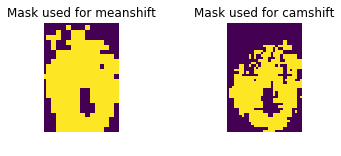

In [17]:
## Display mask image
fig, ax = plt.subplots(1, 2, figsize=(6,2))
ax[0].imshow(mean_mask)
ax[0].set_title('Mask used for meanshift')
ax[0].axis('off')
ax[1].imshow(cam_mask)
ax[1].set_title('Mask used for camshift')
ax[1].axis('off')
plt.show()

__2. Remarks over the performance__

We have tried with different parameters to improve the IoU for the both method. The ones that are selected are the among the best of what we could get. 

One of the remarks that we want to mention is that, when using the camshift, it also detects the neck or sometimes part of background(which has similar color with face). It is probably because they have the same color/brightness with the face. We noticed that if we increase the Value(Brightness) of the lower range of the mask(around 121), the camshift method does not anymore detect the unrelevant parts but also for some frames its detection area shrinks signifcantly. 


__3. Quantitative comparison of the performance of both methods__

From our result based on IoU values, the performance is better when using the meanshift method. Both min and max values are higher when using meanshift method and thus, mean values are also higher. The mean IoU is approximately 15% higher for meanshift result. The min IoU is 12% higher and max IoU is 8% higher for meanshift result.

The camshift method detects more areas with similar colors with the faces so that its boxes are bigger than ground truth boxes. Additionally, the detected areas from the camshift method are usually rotated box so when compared with the ground truth boxes which are not rotated, it affects negatively to the IoU values. We think that if we impose the function to detect the boxes with the same ratio with the roi mask, it may increase the IoU result of the camshift. 

